In [1]:
# import necessary packeges
%matplotlib inline
from matplotlib import pyplot as plt

import numpy as np

import torch
from torch.utils.data import DataLoader
from torch import optim
from torch import nn
import torch.nn.functional as F
from torchvision import datasets, transforms
import helper

from collections import OrderedDict

from sklearn.model_selection import cross_val_score, train_test_split

from torch.utils.data.sampler import SubsetRandomSampler

import time

Get the device. Device is either cuda:0 or cpu

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [3]:
# define a trandform to normalize the data
transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize((0.5,),(0.5,))])

# download the training data
trainset = datasets.FashionMNIST('F_MNIST_data', train=True, download=True, transform=transform)

# download the testing data
testset = datasets.FashionMNIST('F_MNIST_data', train=False, download=True, transform=transform)

print(trainset)
print(testset)

Dataset FashionMNIST
    Number of datapoints: 60000
    Root location: F_MNIST_data
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )
Dataset FashionMNIST
    Number of datapoints: 10000
    Root location: F_MNIST_data
    Split: Test
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )


Devide the training set into a training and a validation set!

In [4]:
shuffle_dataset = True
validation_split = .2
random_seed= 42

trainset_size = len(trainset)
indices = list(range(trainset_size))
split = int(np.floor(validation_split * trainset_size))

if shuffle_dataset :
    np.random.seed(random_seed)
    np.random.shuffle(indices)
train_indices, val_indices = indices[split:], indices[:split]
print(len(train_indices))
print(len(val_indices))

# Creating PT data samplers and loaders:
train_sampler = SubsetRandomSampler(train_indices)
valid_sampler = SubsetRandomSampler(val_indices)


48000
12000


In [5]:
train_loader = DataLoader(trainset, batch_size=64, sampler=train_sampler)
validation_loader = DataLoader(trainset, batch_size=64, sampler=valid_sampler)
test_loader = DataLoader(testset, batch_size=64, shuffle=True)

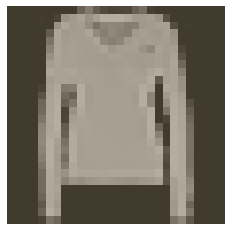

In [6]:
images, labels = next(iter(train_loader))
helper.imshow(images[0,:]);

In [7]:
images.size()

torch.Size([64, 1, 28, 28])

In [8]:
labels.size()

torch.Size([64])

## Building the network

Here you should define your network. As with MNIST, each image is 28x28 which is a total of 784 pixels, and there are 10 classes. You should include at least one hidden layer. We suggest you use ReLU activations for the layers and to return the logits from the forward pass. It's up to you how many layers you add and the size of those layers.

There are two possible ways to build a network: 1. a static one 2. a dynamic one. 
<br>

The dynamic one allows us to configure as many hidden layers as we want just by modifying a parameter list of the hidden layers. This is done with the help of [`nn.ModuleList`](https://pytorch.org/docs/stable/nn.html#modulelist).

In [9]:
class Network(nn.Module):
    def __init__(self, input_layer_size, output_layer_size, hidden_layers, drop_p = 0.5):
        ''' build a feedforward network with arbitraty many hidden layers
        
            Arguments
            ---------
            input_layer: integer, size of the input
            hidden_layers: list of integers, amount and size of the hidden layers
            output_layer: integer, size of the output layer
            drop_p: float between 0 and 1, dropout probability
        '''
        super().__init__()
        # add the first layer input to hidden layer
        self.hidden_layers = nn.ModuleList([nn.Linear(input_layer_size, hidden_layers[0])])
        
        # add a viariable number of more hidden layers
        layer_sizes = zip(hidden_layers[:-1], hidden_layers[1:])
        self.hidden_layers.extend([nn.Linear(h1, h2) for h1, h2 in layer_sizes])
        
        self.output = nn.Linear(hidden_layers[-1], output_layer_size)
        
        self.dropout = nn.Dropout(p = drop_p)
        
    def forward(self,x):
        ''' Forward pass through the network, returns the output logits '''
        
        # Forward through each layer in the hidden_layers, with ReLU activation and dropouts
        for linear in self.hidden_layers:
            x = F.relu(linear(x))
            x = self.dropout(x)
            
        x = self.output(x)
        
        return F.log_softmax(x, dim=1)
                

In [10]:
input_layer = 784
hidden_layers = [800, 600, 400, 200]
output_layer = 10

netmodel = nn.Sequential(OrderedDict([
    ('fcl1', nn.Linear(input_layer, hidden_layers[0])),
    ('relu1', nn.ReLU()),
    ('fcl2', nn.Linear(hidden_layers[0], hidden_layers[0])),
    ('relu2', nn.ReLU()),
    ('fcl3', nn.Linear(hidden_layers[0], hidden_layers[1])),
    ('relu3', nn.ReLU()),
    ('fcl4', nn.Linear(hidden_layers[1], hidden_layers[1])),
    ('relu4', nn.ReLU()),
    ('fcl5', nn.Linear(hidden_layers[1], hidden_layers[2])),
    ('relu5', nn.ReLU()),
    ('fcl6', nn.Linear(hidden_layers[2], hidden_layers[2])),
    ('relu6', nn.ReLU()),
    ('fcl7', nn.Linear(hidden_layers[2], hidden_layers[3])),
    ('relu7', nn.ReLU()),
    ('fcl8', nn.Linear(hidden_layers[3], hidden_layers[3])),
    ('relu8', nn.ReLU()),
    ('output', nn.Linear(hidden_layers[3], output_layer))
]))

netmodel

Sequential(
  (fcl1): Linear(in_features=784, out_features=800, bias=True)
  (relu1): ReLU()
  (fcl2): Linear(in_features=800, out_features=800, bias=True)
  (relu2): ReLU()
  (fcl3): Linear(in_features=800, out_features=600, bias=True)
  (relu3): ReLU()
  (fcl4): Linear(in_features=600, out_features=600, bias=True)
  (relu4): ReLU()
  (fcl5): Linear(in_features=600, out_features=400, bias=True)
  (relu5): ReLU()
  (fcl6): Linear(in_features=400, out_features=400, bias=True)
  (relu6): ReLU()
  (fcl7): Linear(in_features=400, out_features=200, bias=True)
  (relu7): ReLU()
  (fcl8): Linear(in_features=200, out_features=200, bias=True)
  (relu8): ReLU()
  (output): Linear(in_features=200, out_features=10, bias=True)
)

# Train the network

Now you should create your network and train it. First you'll want to define [the criterion](http://pytorch.org/docs/master/nn.html#loss-functions) ( something like `nn.CrossEntropyLoss`) and [the optimizer](http://pytorch.org/docs/master/optim.html) (typically `optim.SGD` or `optim.Adam`).

Then write the training code. Remember the training pass is a fairly straightforward process:

* Make a forward pass through the network to get the logits 
* Use the logits to calculate the loss
* Perform a backward pass through the network with `loss.backward()` to calculate the gradients
* Take a step with the optimizer to update the weights

By adjusting the hyperparameters (hidden units, learning rate, etc), you should be able to get the training loss below 0.4.

Select the network - dynamic or static

In [11]:
nnDynamic = True

In [12]:
if nnDynamic == False:
    criterion = nn.CrossEntropyLoss()
    #optimizer = optim.Adam(netmodel.parameters(), lr=0.001)
    optimizer = optim.Adam(netmodel.parameters(), lr=0.0003)
    #optimizer = optim.SGD(netmodel.parameters(), lr=0.003)

In [13]:
if nnDynamic == True:
    input_layer_size = 784
    output_layer_size = 10
    #hidden_layers_list = [512, 256, 128, 64]
    hidden_layers_list = [800, 800, 600, 600, 400, 400, 200, 200]
    dropout_p = 0.0
    netmodel = Network(input_layer_size, output_layer_size, hidden_layers_list, dropout_p)
    criterion = nn.NLLLoss()
    optimizer = optim.Adam(netmodel.parameters(), lr=0.003)

netmodel

Network(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=784, out_features=800, bias=True)
    (1): Linear(in_features=800, out_features=800, bias=True)
    (2): Linear(in_features=800, out_features=600, bias=True)
    (3): Linear(in_features=600, out_features=600, bias=True)
    (4): Linear(in_features=600, out_features=400, bias=True)
    (5): Linear(in_features=400, out_features=400, bias=True)
    (6): Linear(in_features=400, out_features=200, bias=True)
    (7): Linear(in_features=200, out_features=200, bias=True)
  )
  (output): Linear(in_features=200, out_features=10, bias=True)
  (dropout): Dropout(p=0.0, inplace=False)
)

In [14]:
print(torch.cuda.get_device_properties(device).total_memory)
print(torch.cuda.max_memory_allocated(device))

12652838912
0


In [15]:
epochs = 4
steps = 0
running_loss = 0
print(type(running_loss))
print_every = 40

netmodel.to(device)

start = time.time()

for e in range(epochs):
    running_loss = 0
    for images, labels in iter(train_loader):
        steps += 1
        
        # flatten the imiga into a 784 element vector
        images.resize_(images.size()[0], 784)
        
        images, labels = images.to(device), labels.to(device)
        
        # Clear the gradients, do this because gradients are accumulated
        optimizer.zero_grad()
        
        output = netmodel.forward(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        
        if steps % print_every == 0:
            # Model in inference mode, dropout is off
            netmodel.eval()
        
            accuracy = 0
            valid_loss = 0
            
            for ii, (images, labels) in enumerate(validation_loader):
                
                
                # flatten the imiga into a 784 element vector
                images.resize_(images.size()[0], 784)
                
                with torch.no_grad():
                    images, labels = images.to(device), labels.to(device)

                output = netmodel.forward(images)
                valid_loss += criterion(output, labels).item()
                
                if nnDynamic == True:
                    ps = torch.exp(output)
                else:
                    ps = F.softmax(output, dim=1)
                
                
                equality = (labels.data == ps.max(1)[1])
                
                accuracy += equality.type_as(torch.FloatTensor()).mean()
            
            print("Epoch: {}/{}... ".format(e+1, epochs),
                  "Loss: {:.4f}".format(running_loss/print_every),
                  "Validation Loss: {:.3f}.. ".format(valid_loss/len(validation_loader)),
                  "Validation Accuracy: {:.3f}".format(accuracy/len(validation_loader)))
            
            running_loss = 0
            
            # Make sure dropout is on for training
            netmodel.train()
            
print("Time for training and validation : {:.0f} minutes and {:.3f} seconds".format((time.time() - start)/60, (time.time() - start) % 60))

<class 'int'>
Epoch: 1/4...  Loss: 2.1418 Validation Loss: 1.753..  Validation Accuracy: 0.193
Epoch: 1/4...  Loss: 1.6854 Validation Loss: 1.605..  Validation Accuracy: 0.300
Epoch: 1/4...  Loss: 1.5149 Validation Loss: 1.465..  Validation Accuracy: 0.287
Epoch: 1/4...  Loss: 1.4511 Validation Loss: 1.297..  Validation Accuracy: 0.405
Epoch: 1/4...  Loss: 1.2591 Validation Loss: 1.008..  Validation Accuracy: 0.497
Epoch: 1/4...  Loss: 1.0644 Validation Loss: 0.998..  Validation Accuracy: 0.551
Epoch: 1/4...  Loss: 0.9648 Validation Loss: 1.018..  Validation Accuracy: 0.545
Epoch: 1/4...  Loss: 0.8738 Validation Loss: 0.907..  Validation Accuracy: 0.658
Epoch: 1/4...  Loss: 0.8749 Validation Loss: 1.014..  Validation Accuracy: 0.586
Epoch: 1/4...  Loss: 0.8661 Validation Loss: 0.818..  Validation Accuracy: 0.675
Epoch: 1/4...  Loss: 0.8009 Validation Loss: 0.755..  Validation Accuracy: 0.721
Epoch: 1/4...  Loss: 0.7416 Validation Loss: 0.826..  Validation Accuracy: 0.670
Epoch: 1/4... 

In [16]:
print(torch.cuda.get_device_properties(device).total_memory)
print(torch.cuda.max_memory_allocated(device))
print(torch.cuda.memory_allocated(device))
torch.cuda.empty_cache()
print(torch.cuda.max_memory_allocated(device))
print(torch.cuda.memory_allocated(device))

12652838912
48767488
43440640
48767488
43440640


In [17]:
netmodel.eval()

netmodel.to(device)
        
accuracy = 0
test_loss = 0

for ii, (images, labels) in enumerate(test_loader):


    # flatten the imiga into a 784 element vector
    images.resize_(images.size()[0], 784)

    with torch.no_grad():
        images, labels = images.to(device), labels.to(device)

    output = netmodel.forward(images)

    if nnDynamic == True:
        ps = torch.exp(output)
    else:
        ps = F.softmax(output, dim=1)
    

    equality = (labels.data == ps.max(1)[1])

    accuracy += equality.type_as(torch.FloatTensor()).mean()

print("Test Accuracy: {:.3f}".format(accuracy/len(test_loader)))

running_loss = 0

Test Accuracy: 0.812


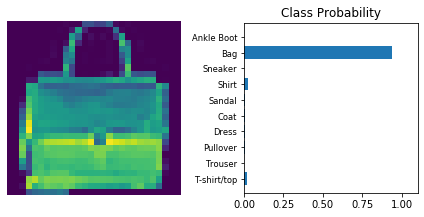

In [18]:
# Test out your network!
netmodel.to(device)

netmodel.eval()

dataiter = iter(test_loader)
images, labels = dataiter.next()

images, labels = images.to(device), labels.to(device)

img = images[0]
# Convert 2D image to 1D vector
img = img.resize_(1, 784)

# Turn off gradients to speed up this part
with torch.no_grad():
    output = netmodel.forward(img)

if nnDynamic == True:
    ps = torch.exp(output)
else:
    ps = F.softmax(output, dim=1)

#print(ps.size())
#print(ps.max(1)[1])

#print(ps.device, img.device)
if device != 'cpu':
    ps = ps.cpu()
    img = img.cpu()
#print(ps.device, img.device)

# Plot the image and probabilities
helper.view_classify(img.resize_(1, 28, 28), ps, version='Fashion')